In [5]:
import scripts.read_land_use_no_gdal as land_use
import scripts.read_image_data as rid
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline

In [6]:
# from importlib import reload
# reload(rid)

In [7]:
ds = rid.read_image_data(image_dir='area1/2014/images/', 
                         mask_dir='area1/2014/masks/', 
                         table_dir='area1/2014/tables/LC8_SR.csv')
ds_new = rid.read_image_data(image_dir='area1/2015/images/', 
                             mask_dir='area1/2015/masks/',
                             table_dir='area1/2015/tables/LC8_SR.csv')

In [8]:
res = ds[list(ds.keys())[0]].shape

In [9]:
# polygon = "POLYGON ((144.0229424345357 -37.55299953752239, 144.02019905996406 -37.97282887730929, 144.6632499098556 -37.972670022747636, 144.66240633494579 -37.552454710108975, 144.0229424345357 -37.55299953752239))"
polygon = "POLYGON ((143.32317350376297 -37.496296386368165, 143.32180000642074 -37.70330610816869,\
                        143.59543478539388 -37.70317028876007, 143.5968081449812 -37.49575155973978,\
                        143.32317350376297 -37.496296386368165))"
# polygon = "POLYGON ((142.79501249253747 -37.62573016158374, 142.79363481285884 -37.832739875957245,\
#                         143.06774894788782 -37.83260406398416, 143.0691229156846 -37.62518532754736,\
#                         142.79501249253747 -37.62573016158374))"
array, unique_classes = land_use.read_land_use(buffer=-0.0001, area_filter=polygon, resolution=(res[2], res[1]))

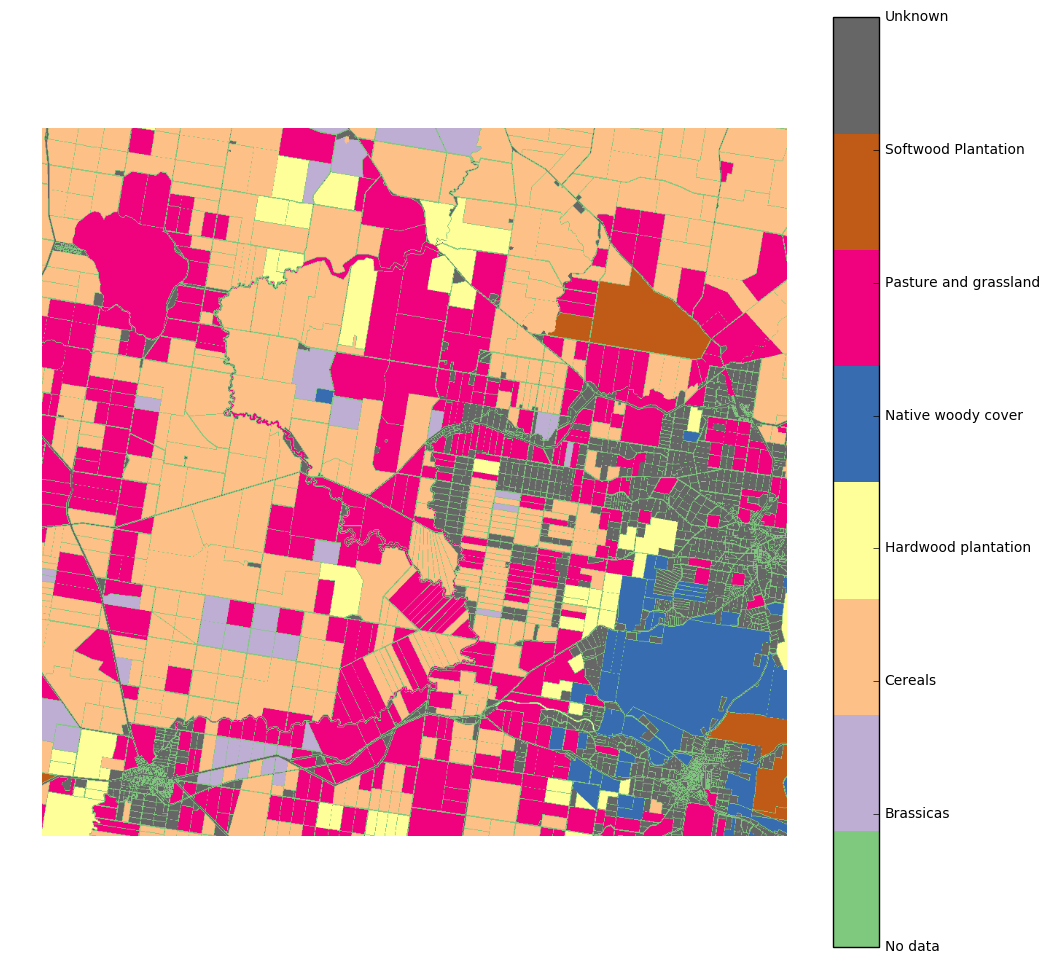

In [10]:
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(array, cmap=plt.cm.get_cmap('Accent', len(unique_classes)))
plt.colorbar(ticks=range(len(unique_classes)), format=plt.FuncFormatter(lambda val, loc: unique_classes[val]))
plt.show()

In [7]:
train, to_predict = rid.generate_interpolated_training_set(ds, ds_new, labels=array, max_days_apart=60)

/home/mithrillion/anaconda3/lib/python3.5/site-packages/pandas/tools/merge.py:205: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import xgboost as xgb
# from sklearn.cross_validation import cross_val_score
# from sklearn.cross_validation import train_test_split

/home/mithrillion/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
# clf = RandomForestClassifier(n_estimators=100, max_depth=None, 
#                              min_samples_leaf=20, 
#                              random_state=0, n_jobs=8)

In [10]:
unique_classes

{0: 'No data',
 1: 'Brassicas',
 2: 'Cereals',
 3: 'Hardwood plantation',
 4: 'Native woody cover',
 5: 'Pasture and grassland',
 6: 'Softwood Plantation',
 7: 'Unknown'}

In [11]:
X = train.ix[~np.in1d(train.ix[:, 'label'], [0]), 2:-1]
y = train.ix[~np.in1d(train.ix[:, 'label'], [0]), 'label']

In [12]:
Counter(y)

Counter({1: 31988,
         2: 377392,
         3: 48314,
         4: 48084,
         5: 282968,
         6: 20597,
         7: 94490})

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y - 1, test_size=0.33, random_state=42)
# model = clf.fit(X_train, y_train)
# pred = clf.predict(X_test)
# print(classification_report(y_test, pred))

In [14]:
unknown_class = 6 # adjusted to [0..num_class]
dtrain = xgb.DMatrix(X_train.ix[y_train != unknown_class, :], label=y_train[y_train != unknown_class],
                    missing = -999)
# specify parameters via map
param = {'max_depth':17, 'eta':0.2, 'objective':'multi:softprob', 'num_class': len(Counter(y)), 
         'min_child_weight': 50}
num_round = 20

In [15]:
model = xgb.train(param, dtrain, num_round)

In [16]:
# xgb.cv(param, dtrain, num_round, nfold=4, stratified=True)

In [17]:
dtest = xgb.DMatrix(X_test, label=y_test, missing = -999)
pred = model.predict(dtest)

In [18]:
def select_class_or_unknown(probs, threshold=0.5, unknown_class=6):
    if np.max(probs) > threshold:
        return np.argmax(probs)
    else:
        return unknown_class
pred_labels = np.apply_along_axis(select_class_or_unknown, 1, pred, unknown_class=6, threshold=0.5)

In [19]:
Counter(pred_labels)

Counter({0: 8412, 1: 124043, 2: 11913, 3: 19201, 4: 108247, 5: 6565, 6: 19884})

In [20]:
print(classification_report(y_test, pred_labels))

             precision    recall  f1-score   support

          0       0.98      0.78      0.87     10577
          1       0.92      0.92      0.92    124530
          2       0.93      0.70      0.80     15892
          3       0.73      0.89      0.80     15765
          4       0.77      0.90      0.83     93157
          5       0.95      0.90      0.92      6919
          6       0.25      0.16      0.19     31425

avg / total       0.80      0.81      0.80    298265



In [21]:
X_new = to_predict.iloc[:, 2:]
cls_table = to_predict.iloc[:, :2]

In [22]:
pred_new = model.predict(xgb.DMatrix(X_new, feature_names=[str(n) for n in X.columns]))

In [35]:
pred_new_labels = np.apply_along_axis(select_class_or_unknown, 1, pred_new, unknown_class=6, threshold=0.3)

In [36]:
Counter(pred_new_labels)

Counter({0: 509, 1: 530022, 2: 14225, 3: 62084, 4: 311227, 5: 37264, 6: 39075})

In [37]:
cls_table['pred_label'] = pred_new_labels + 1
cls_map = cls_table.pivot(index='x', columns='y', values='pred_label')

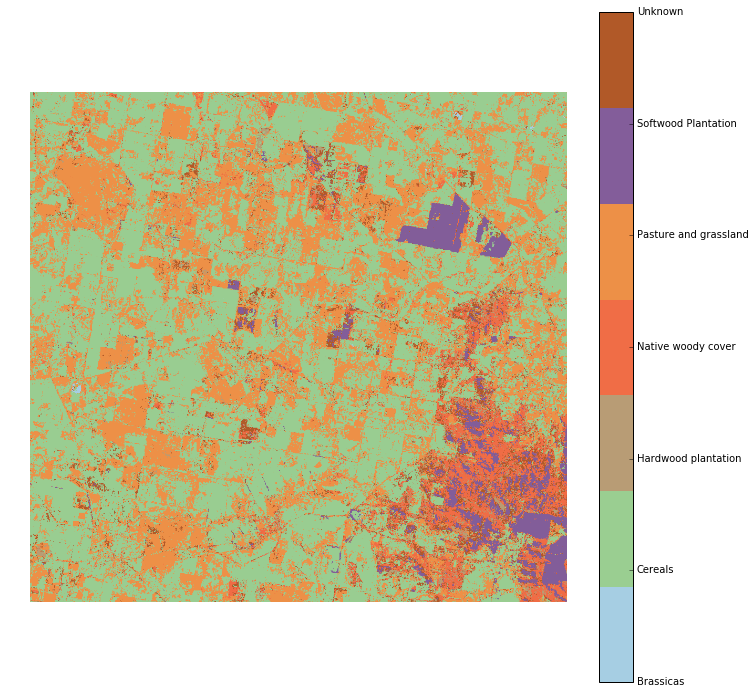

In [38]:
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(cls_map, cmap=plt.cm.get_cmap('Paired', len(unique_classes) - 1))
plt.colorbar(ticks=range(1, len(unique_classes)), format=plt.FuncFormatter(lambda val, loc: unique_classes[val]))
plt.show()